In [3]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace

import numpy as np

In [17]:
# Dictionary of supported code tableaus
code_library = {
    "phase_flip": {
        "label": (3,1,2),
        "tableau": [
            "XXI",
            "IXX",
        ],
    },
    "four": {
        "label": (4,2,2),
        "tableau": [
            "XZZX",
            "YZZY",
        ],
    },
    "five": {
        "label": (5,1,3),
        "tableau": [
            "XZZXI",
            "IXZZX",
            "XIXZZ",
            "ZXIXZ",
        ],
    },
    "steane": {
        "label": (7,1,3),
        "tableau": [
            # "XXXXIII",
            # "IXXIIXX",
            # "XIXIXIX",
            # "ZZZZIII",
            # "IZZIIZZ",
            # "ZIZIZIZ",
            "XXXXIII", # LogicalDemo (Qtm paper) stabilizers
            "IXXIXXI",
            "IIXXIXX",
            "ZZZZIII",
            "IZZIZZI",
            "IIZZIZZ",
        ],
    },
    "eight": {
        "label": (8,3,3),
        "tableau": [
            "XXXXXXXX",
            "ZZZZZZZZ",
            "IXIXYZYZ",
            "IXZYIXZY",
            "IYXZXZIY",
        ],
    },
}

In [8]:
# Function which generates the code gadgets for a given tableau
def generate_code(code):
    # The number of qubits is equal to the length of any stabilizer
    label = code["label"]
    n, k, d = label
    print(f"Stabilizer code: [[{n}, {k}, {d}]]")

    tableau = code["tableau"]
    m = len(tableau)

    # Step 1: Assemble generator matrix
    G = np.zeros((2, m, n))
    for i, stabilizer in enumerate(tableau):
        for j, pauli_j in enumerate(stabilizer):
            if pauli_j == "X":
                G[0, i, j] = 1
            elif pauli_j == "Z":
                G[1, i, j] = 1
            elif pauli_j == "Y":
                G[:, i, j] = 1

    print("Generator matrix (non-standard form):\n", G)

    # Step 2: Perform Gaussian reduction in base 2
    row = 0
    for col in range(n):
        pivot_row = None
        for i in range(row, m):
            if G[0, i, col] == 1:
                pivot_row = i
                break
        
        if pivot_row is None:
            continue
        
        G[:, [row, pivot_row]] = G[:, [pivot_row, row]]

        # Flip any other rows with a "1" in the same column
        for i in range(m):
            if i != row and G[0, i, col] == 1:
                G[:, i] = G[:, i].astype(int) ^ G[:, row].astype(int)
                # G[0, i] = G[0, i].astype(int) ^ G[0, row].astype(int)
                # G[1, i] = G[1, i].astype(int) ^ G[1, row].astype(int)

        # Move to the next row, if we haven't reached the end of the matrix
        row += 1
        if row >= m:
            break

    r = np.linalg.matrix_rank(G[0])

    E = np.copy(G[:, r:, r:])
    row = 0
    for col in range(n-r):
        pivot_row = None
        for i in range(row, m-r):
            if E[1, i, col] == 1:
                pivot_row = i
                break
        
        if pivot_row is None:
            continue
        
        E[:, [row, pivot_row]] = E[:, [pivot_row, row]]
        G[:, [r+row, r+pivot_row]] = G[:, [r+pivot_row, r+row]]

        # Flip any other rows with a "1" in the same column
        for i in range(m-r):
            if i != row and E[1, i, col] == 1:
                E[:, i] = E[:, i].astype(int) ^ E[:, row].astype(int)
                G[:, r+i] = G[:, r+i].astype(int) ^ G[:, r+row].astype(int)

        # Move to the next row, if we haven't reached the end of the matrix
        row += 1
        if row >= m:
            break

    # print("E:\n", E)
    print("Generator matrix (standard form):\n", G)

    # Step 3: Construct logical operators using Pauli vector representations
    r = np.linalg.matrix_rank(G[0])
    A_2 = G[0, 0:r,   m:n] # r x k
    C_1 = G[1, 0:r,   r:m] # r x m-r
    C_2 = G[1, 0:r,   m:n] # r x k
    E_2 = G[1, r:m,   m:n] # m-r x k
    # print(A_2)
    # print(C_1)
    # print(C_2)
    # print(E_2)

    LogicalXVec = np.block([
        [[np.zeros((k, r)),      E_2.T,              np.eye(k, k)    ]],
        [[E_2.T @ C_1.T + C_2.T, np.zeros((k, m-r)), np.zeros((k, k))]]
    ])
    print("Logical X operator vector:\n", LogicalXVec)

    LogicalZVec = np.block([
        [[np.zeros((k, r)), np.zeros((k, m-r)), np.zeros((k, k))]],
        [[A_2.T,            np.zeros((k, m-r)), np.eye(k, k)    ]]
    ])
    print("Logical Z operator vector:\n",  LogicalZVec)

    # Step 4: Apply the respective stabilizers
    encoding_circuit = QuantumCircuit(n)
    for i in range(k):
        for j in range(r, n-k):
            if LogicalXVec[0, i, j]:
                encoding_circuit.cx(n-k+i, j)
    
    for i in range(r):
        encoding_circuit.h(i)
        for j in range(n):
            if i != j:
                if G[0, i, j]:
                    encoding_circuit.cx(i, j)
                elif G[1, i, j]:
                    encoding_circuit.cz(i, j)
                elif G[0, i, j] and G[1, i, j]:
                    encoding_circuit.cx(i, j)
                    encoding_circuit.cz(i, j)
    EncodeGate = encoding_circuit.to_gate(label="$U_{enc}$")

    # Step 5: Construct logical operators
    # Logical PauliX - Gottesman's method
    LogicalXCircuit = QuantumCircuit(n)
    for i in range(k):
        # X part
        for q, bit in enumerate(LogicalXVec[0][i]):
            if bit == 1:
                LogicalXCircuit.x(q)
        # Z part
        for q, bit in enumerate(LogicalXVec[1][i]):
            if bit == 1:
                LogicalXCircuit.z(q)
    LogicalXGate = LogicalXCircuit.to_gate(label="$X_L$")

    # Logical PauliZ - Gottesman's method
    LogicalZCircuit = QuantumCircuit(n)
    for i in range(k):
        # X part
        for q, bit in enumerate(LogicalZVec[0][i]):
            if bit == 1:
                LogicalZCircuit.x(q)
        # Z part
        for q, bit in enumerate(LogicalZVec[1][i]):
            if bit == 1:
                LogicalZCircuit.z(q)
    LogicalZGate = LogicalZCircuit.to_gate(label="$Z_L$")

    # Logical Hadamard - Childs and Wiebe's linear combination of unitaries method
    LogicalHCircuit = QuantumCircuit(n+1)
    LogicalHCircuit.h(n)
    
    LogicalHCircuit.append(LogicalXGate.control(1), [n, *list(range(n))])

    LogicalHCircuit.x(n)
    LogicalHCircuit.append(LogicalZGate.control(1), [n, *list(range(n))])
    LogicalHCircuit.x(n)
    
    LogicalHCircuit.h(n)
    LogicalHGate = LogicalHCircuit.to_gate(label="$H_L$")
 
    return encoding_circuit, EncodeGate, LogicalXGate, LogicalZGate, LogicalHGate

# Test case: Steane [[7,1,3]] code
First, we test our function on the Steane code, a very simple CSS code for which we can quickly read off whether or not the output is correct.

Stabilizer code: [[7, 1, 3]]
Generator matrix (non-standard form):
 [[[1. 1. 1. 1. 0. 0. 0.]
  [0. 1. 1. 0. 1. 1. 0.]
  [0. 0. 1. 1. 0. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 0. 0.]
  [0. 1. 1. 0. 1. 1. 0.]
  [0. 0. 1. 1. 0. 1. 1.]]]
Generator matrix (standard form):
 [[[1. 0. 0. 1. 1. 1. 0.]
  [0. 1. 0. 1. 1. 0. 1.]
  [0. 0. 1. 1. 0. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 0. 0.]
  [1. 0. 1. 0. 1. 0. 1.]
  [1. 1. 0. 0. 0. 1. 1.]]]
Logical X operator vector:
 [[[0. 0. 0. 0. 1. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0.]]]
Logical Z operator vector:
 [[[0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 1. 0. 0. 0. 1.]]]


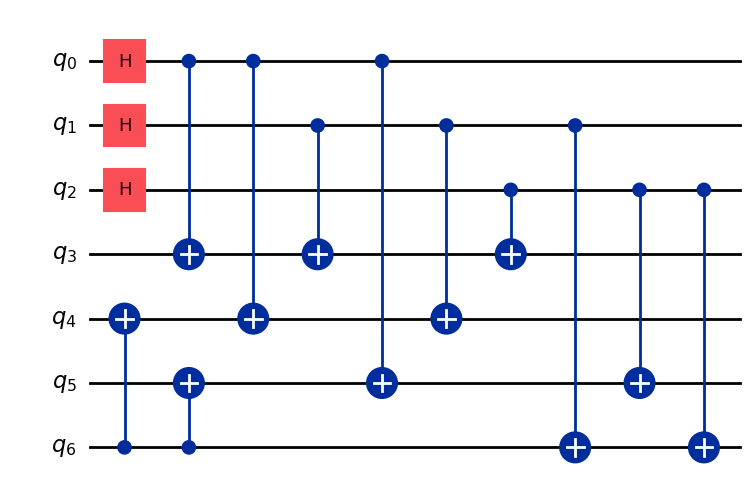

In [18]:
encoding_circuit, EncodeGate, LogicalXGate, LogicalZGate, LogicalHGate = generate_code(code_library["steane"])
encoding_circuit.draw('mpl')

In [12]:
print("Total gate count:", encoding_circuit.size())
print("CNOT gate count:", encoding_circuit.count_ops()["cx"])
print("Circuit depth:", encoding_circuit.depth())

Total gate count: 14
CNOT gate count: 11
Circuit depth: 6


In [19]:
qc_zero_L = QuantumCircuit(7).compose(EncodeGate, qubits=list(range(7)))
qc_one_L = QuantumCircuit(7).compose(EncodeGate, qubits=list(range(7))).compose(LogicalXGate, qubits=list(range(7)))
# qc_plus_L = QuantumCircuit(7).compose(EncodeGate, qubits=list(range(7))).compose(LogicalHGate, qubits=list(range(7+1)))

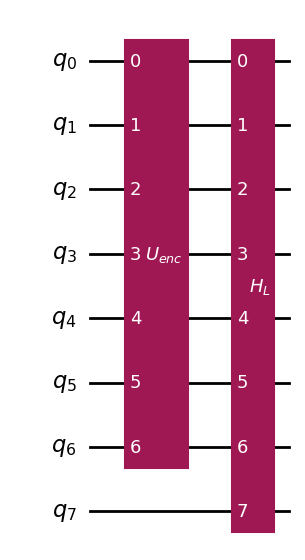

In [55]:
qc_plus_L.draw("mpl")

In [20]:
zero_L_full = Statevector.from_instruction(qc_zero_L)
one_L_full = Statevector.from_instruction(qc_one_L)
#plus_L_full = Statevector.from_instruction(qc_plus_L)

In [21]:
zero_L_full.draw("latex")

<IPython.core.display.Latex object>

In [22]:
one_L_full.draw("latex")

<IPython.core.display.Latex object>

In [59]:
plus_L_full.draw("latex")

<IPython.core.display.Latex object>

In [60]:
zero_L = partial_trace(zero_L_full, [7])
one_L = partial_trace(one_L_full, [7])
plus_L = partial_trace(plus_L_full, [7])

QiskitError: 'Max qargs_l is larger than number of left qargs'

In [61]:
print(np.sqrt(np.count_nonzero(zero_L)), np.shape(one_L))
zero_L.to_statevector().draw("latex")

8.0 (128, 128)


<IPython.core.display.Latex object>

In [62]:
print(np.sqrt(np.count_nonzero(one_L)), np.shape(one_L))
one_L.to_statevector().draw("latex")

8.0 (128, 128)


<IPython.core.display.Latex object>

In [63]:
print(np.sqrt(np.count_nonzero(plus_L)), np.shape(one_L))
plus_L.draw("latex")

128.0 (128, 128)


<IPython.core.display.Latex object>

In [64]:
error_H_abs = np.abs(np.sum(0.5**0.5 * (zero_L + one_L) - plus_L))
error_H_rel = error_H_abs/np.size(zero_L)
print(f"Hadamard gate performance\nAbsolute error: {error_H_abs}\nRelative error: {error_H_rel}")

Hadamard gate performance
Absolute error: 0.8284271247461932
Relative error: 5.056317900062214e-05
